# 準ニュートン法の実装解説
- 本notebookでは、以下コードを参考にその解説をしていきます
- https://github.com/ysakamot15/optimization
- 勉強会資料：　https://drive.google.com/drive/u/1/folders/1hUG_39oZhNRpL2WeR5YfISSGh2RF1xun

## 問題
$ \min: c^{T}x $
$ \\ s.t.  Ax \leq x $
$ \  x \geq 0 $

### 準ニュートン法のステップ
教科書(p107)あるいは勉強会資料の通りです

---

1. 適当な初期点（正定値）を決めて、$H_0$の近似正定値行列 $B_0$を作ります
2. $ d(x^k) = -B^{-1} \nabla f(x^k) $ に沿って、直線探索しアルミホ条件を満たすステップ幅αを求めます
3. $ x^{k+1} = x^k + α_kd(x^k) $ として更新します
4. みんな大好きBFGS公式を使って、$B_{k+1}$を作ります
5. $ \nabla^2 f(x^k) $ が十分小さければ終了します

---

### 準備1　目的関数を定義します
- 目的関数： $ (x_1 - 2)^4 + (x_1 - 2x_2)^2 $
- 勾配　$\nabla f$: $ 4(x_1-2)^3 + 2(x_1-2x_2)$
- 二階微分 $\nabla^2 f$:

In [ ]:
class objective_function_test3:
    def __init__(self):
        self.dim = 2

    def func(self, x):
        return (x[0] - 2) ** 4 + (x[0] - 2 * x[1]) ** 2

    def grad(self, x):
        return np.array([4 * (x[0] - 2) ** 3 + 2 * (x[0] - 2 * x[1]),
                        -4 *  (x[0] - 2 * x[1])])


### 準備　ステップ幅αを計算する関数を用意します
$g(α)$を、$x$において目的関数$f(x)$が$d$の方向にαの幅で向かう関数と定義します：

$\\ g(α) = f(x^k + αd(x^k)) $

アルミホ条件はある定数 0 < τ < 1 に対してαが以下を満たすことです：
$ g(α) \leq g(0) + τg^{\prime}(0)α $

上記を満たすαを、少しずつ更新しながら得ていきます

In [38]:
from IPython.display import Image
import numpy as np

def backtracking_line_search(objective, x, d, tau1, beta):
    alpha = 1
    g = lambda alpha : objective.func(x + alpha * d)
    g_dash = lambda alpha : objective.grad(x + alpha * d) @ d
    while(1):
        if ((g(alpha) <= g(0) + tau1 * g_dash(0) * alpha)):
                break
        alpha *= beta
    return alpha

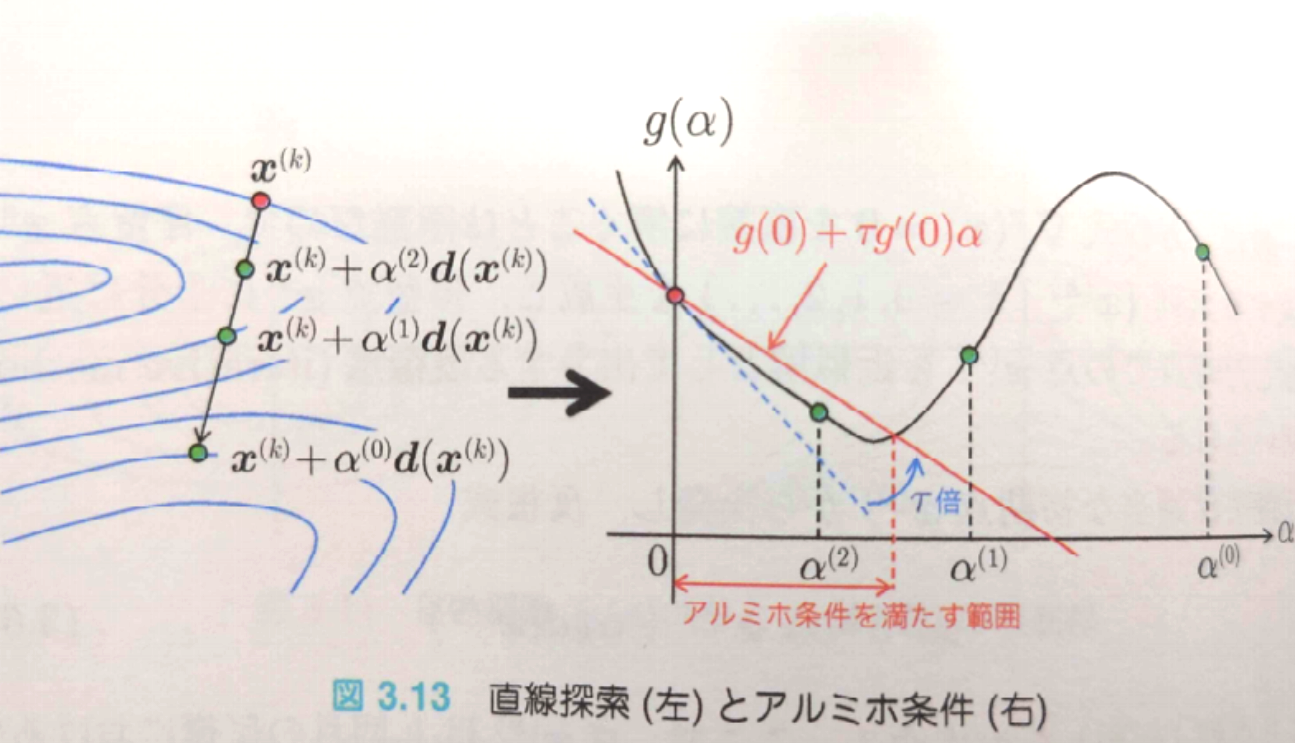

In [39]:
Image("image/almiho.jpg")

### 本番　


In [40]:
def quasi_newton(objective, eps = 1e-9, tau1 = 0.5, beta = 0.9):
    # Step1. 適当な初期の正定値行列Bを決めます。単位行列は正定値行列です
    H = np.eye(objective.dim) # = inv(B)
    # 探索の初期値を適当に用意します
    x = np.random.randn(objective.dim)

    while(1):
        #ステップ２
        #勾配を求めます
        grad = objective.grad(x)
        if(np.linalg.norm(grad) <= eps):
            break
        d = - H @ grad
        alpha = backtracking_line_search(objective, x, d, tau1, beta)
        x_new = x + alpha * d
        s = (x_new - x)[:, None]
        y = (objective.grad(x_new) - grad)[:, None]
        I = np.eye(H.shape[0])
        sy = (s.T @ y)
        H = (I - (s @ y.T) / sy)  @ H @ (I - (y @ s.T) / sy) + (s @ s.T / sy)
        x = x_new
    return x, objective.func(x)

In [41]:
class objective_function_test:
    def __init__(self):
        self.dim = 2

    def func(self, x):
        return (x[0] - 2) ** 4 + (x[0] - 2 * x[1]) ** 2

    def grad(self, x):
        return np.array([4 * (x[0] - 2) ** 3 + 2 * (x[0] - 2 * x[1]),
                        -4 *  (x[0] - 2 * x[1])])

In [42]:
#objective = objective_function_test1()
#print(quasi_newton(objective, eps=1e-6))

#objective = objective_function_test2()
#print(quasi_newton(objective, eps=1e-6))

objective = objective_function_test()
print(quasi_newton(objective, eps=1e-6))

#objective = objective_function_test4(200)
#print(quasi_newton(objective, eps=1e-3))

(array([1., 1.]), 0.0)
(array([1.36073797e-15, 4.32148341e-03]), 1.0462913988442977e-09)
(array([1.99375407, 0.99687703]), 1.5219100061658394e-09)
(array([  15.20382468,  -57.40630478,  -88.14756789,   48.83556791,
         84.05152179,    1.00837474,   55.96127375,  -29.12365159,
        -13.79992236,   74.53793415,   26.13167494,   88.36414117,
        106.36672657,   99.84720253,   17.93870614,    4.90390746,
        -18.60433374,   74.85810981,  -46.07285461,  -18.5518315 ,
         51.31488157,  -48.75217257,  -79.90857928,   14.31277698,
        -68.31490349,   65.12798128,   38.62618876,  -78.09577457,
         10.76502376,  -61.70708996,  -34.71861534,   77.69392924,
         38.32496952,   35.27387121,   58.61437331,  -21.44589486,
         -3.42162559,   36.88734579,  106.17486598,   -0.38657855,
        -40.46339361,   29.55452036,  -57.54107972,  164.5048054 ,
         52.87328111,  100.411569  ,  -81.66688594,  -80.47896115,
        -55.9254018 ,    4.90828867,  -71.616541